   # TP IA Kenny Huber/Léonard Najman/ Hugo Teinturier
   ### Prédiction cours cryptomonnaies Deep Learning

Pour ce Tp nous allons utiliser la methode long-short-term memory (LSTM) recurrent neural network (RNN). 

Lors d'un réseau de neurones classique le gradient des couches peut devenir extrêmement petit et très proche de 0, notamment quand il y a beaucoup de données. Avoir un gradient proche de 0 , réduit considérablement la vitesse d'apprentissage du modèle. Le modèle peut ne même ne plus apprendre du tout. 

L'idée associée au LSTM est que chaque unité computationnelle est liée non seulement à un état caché h mais également à un état c de la cellule qui joue le rôle de mémoire. Le passage de c_t-1 à c_t se fait par transfert à gain constant et égal à 1. 
De cette façon les erreurs se propagent aux pas antérieurs sans phénomène de disparition de gradient. L'état de la cellule peut être modifié à travers une porte qui autorise ou bloque la mise à jour appelée (input gate). 
De même une porte contrôle si l'état de cellule est communiqué en sortie de l'unité LSTM (output gate). La version la plus répandue des LSTM utilise aussi une porte permettant la remise à zéro de l'état de la cellule (forget gate)6.


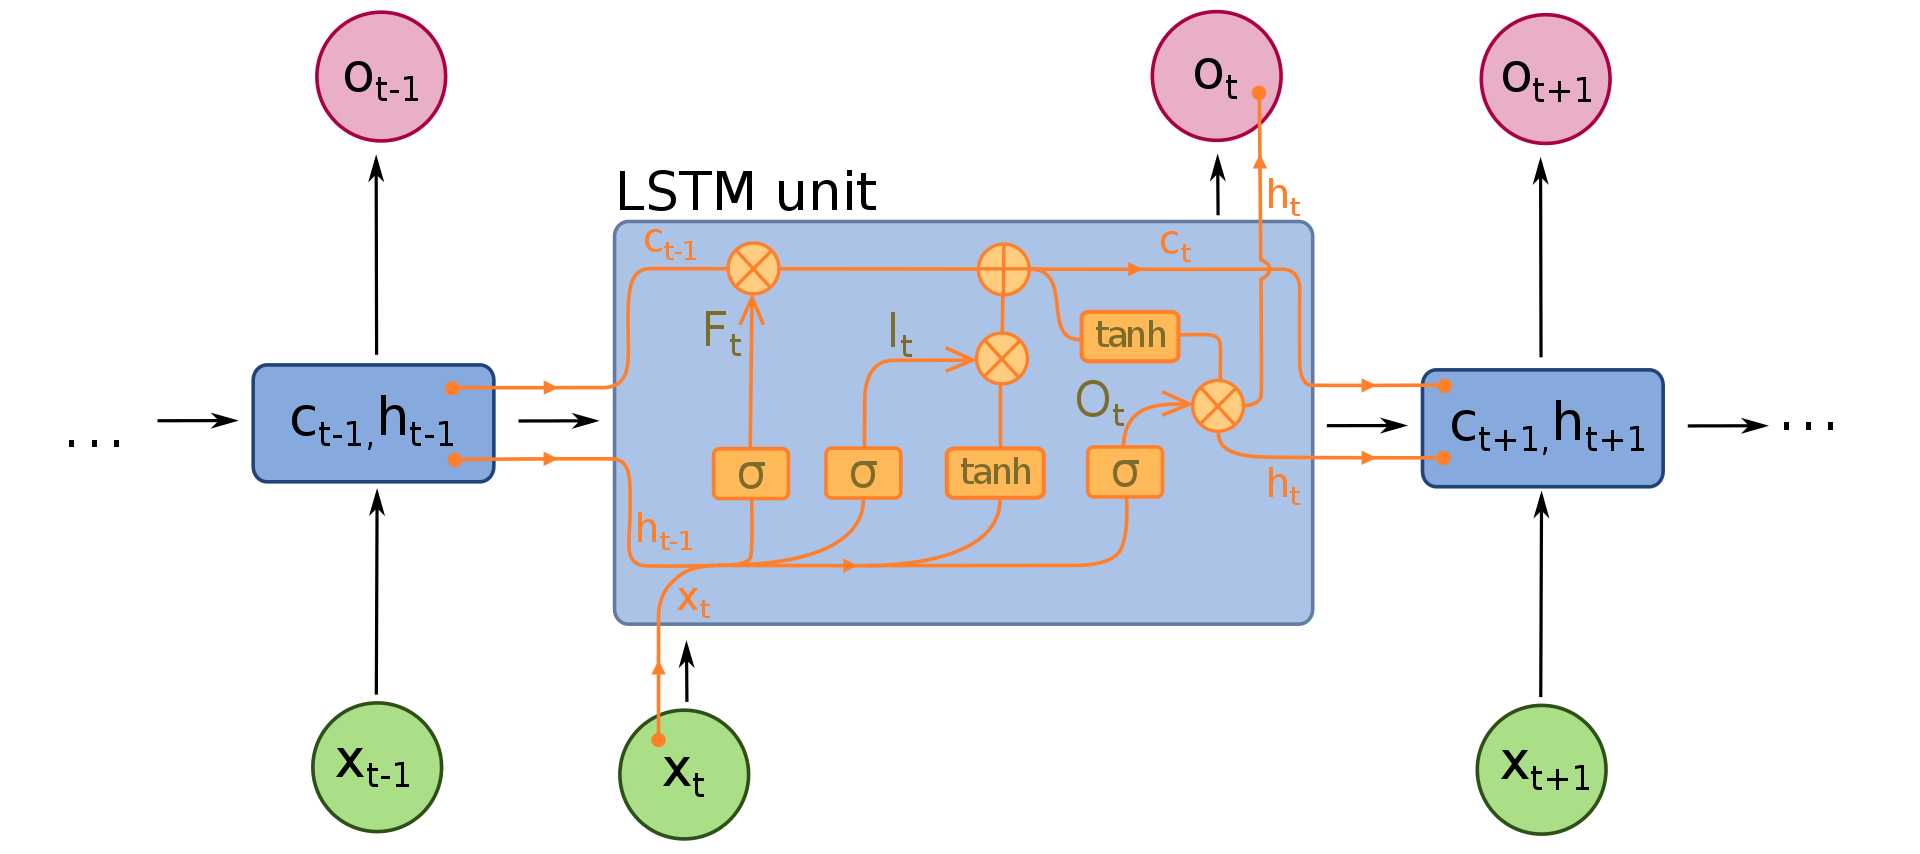


Dans un LSTM on a donc trois portes : entrée, oublier et sortie porte. Ces portes déterminent s'il faut ou non laisser entrer une nouvelle entrée (porte d'entrée), supprimer l'information car elle n'est pas importante (oublier la porte) ou la laisser influencer la sortie au pas de temps courant (porte de sortie).

# Les Librairies

On utilise les librairies classique de python permettant la manipulation de données (numpy,panda,matplotlib,math).

Contrairement au tp de machine learning du premier semestre nous avons décidé d'utiliser des librairies de machine learning afin de comprendre leur fonctionnement. On import donc : 
- sklearn qui permet d'utiliser certaine fonction comme MinMaxScaler ou mean-squarred_error permettant de calculer l'erreur du modele. Sklearn est aussi connu pour faire des régressions. 
- keras qui est une des librairies les plus connues pour le deepl learning. On aurait aussi pu utiliser torch, tensorflow...


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# La base de donnée 
Notre Tp étant sur les cryptomonnaies nous avons décidé de choisir le Bitcoin, cryptomonnaie la plus connue, la plus chère, et ayant donc une volatilité peut être plus faible que les autres cryptos. Rendant ainsi notre prédiction peut etre plus fiable.

On a récupéré un csv à partir du site Kaggle, que l'on va charger à l'aide de panda.


Dans notre csv nous avons pleins de paramètres, uniquement le prix de clôture et la date nous intéresse, on crée donc un dataframe du prix de clôture et de la date

In [2]:
data = pd.read_csv("coin_Bitcoin.csv")
data

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
...,...,...,...,...,...,...,...,...,...,...
2857,2858,Bitcoin,BTC,2021-02-23 23:59:59,54204.929756,45290.590268,54204.929756,48824.426869,1.061025e+11,9.099259e+11
2858,2859,Bitcoin,BTC,2021-02-24 23:59:59,51290.136695,47213.498162,48835.087661,49705.333316,6.369552e+10,9.263931e+11
2859,2860,Bitcoin,BTC,2021-02-25 23:59:59,51948.966982,47093.853019,49709.082425,47093.853019,5.450657e+10,8.777661e+11
2860,2861,Bitcoin,BTC,2021-02-26 23:59:59,48370.785260,44454.842114,47180.464054,46339.760083,3.509679e+11,8.637523e+11


### Création du dataframe final 

In [3]:
final_data=pd.DataFrame({'Cours_Bitcoin': data["Close"],'Date': data['Date']})
final_data

,Cours_Bitcoin,Date
0,144.539993,2013-04-29 23:59:59
1,139.000000,2013-04-30 23:59:59
2,116.989998,2013-05-01 23:59:59
3,105.209999,2013-05-02 23:59:59
4,97.750000,2013-05-03 23:59:59
...,...,...
2857,48824.426869,2021-02-23 23:59:59
2858,49705.333316,2021-02-24 23:59:59
2859,47093.853019,2021-02-25 23:59:59
2860,46339.760083,2021-02-26 23:59:59


On enlève les heures minutes et seconde de la date. 

In [4]:
datee=[]
for val in final_data['Date']:
    datee.append(val[:10])
final_data['Date']=datee

# Mise en place des données
On récupère les valeurs du dataframe pour s'assurer que ce soit bien des floats et sous forme d'un numpy array


In [5]:
dataset = final_data[['Cours_Bitcoin']]
dataset = dataset.astype('float32')

In [6]:
dataset

,Cours_Bitcoin
0,144.539993
1,139.000000
2,116.989998
3,105.209999
4,97.750000
...,...
2857,48824.425781
2858,49705.332031
2859,47093.851562
2860,46339.761719


Nos valeurs doivent être en 0 et 1 pour utiliser les fonctions d'activation des couches comme la sigmoid. Contrairement au premier semestre nous utilisons la fonction MinMaxScaler de la librairie sklearn pour se faire, ce qui nous évite de le faire manuellement.

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [8]:
dataset.shape

(2862, 1)

# Création des matrices X train et Y train

La norme pour la répartition des matrices et d'environs 70% pour les matrices de training et 30 % pour les matrices de test. Nous avons manuellement fait cette répartition. Nous aurions pu utiliser la fonction train_test_split() de sklearn qui permet de faire une répartition au hasard des matrices. Prendre 70% de valeur au hasard plutôt que les70% premières est souvent plus efficaces pour l'apprentissage du model et la prédiction des valeurs. Nous avons cependant privilégié la première méthode qui nous permet par la suite de plot les résultats de façon plus simple et rapide.


In [9]:
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

2003 859


Definissons create_dataset, qui a deux inputs:

1. Dataset - l'array numpy que l'on veut convertir en dataset
2. look_back - le nombre d'étape précédente pour prédire la prochaine période temporelle


In [10]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [11]:
look_back = 10
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [12]:
trainX

array([[0.00132429, 0.0012279 , 0.00084492, ..., 0.00076332, 0.0007494 ,
        0.00078535],
       [0.0012279 , 0.00084492, 0.00063995, ..., 0.0007494 , 0.00078535,
        0.00076976],
       [0.00084492, 0.00063995, 0.00051015, ..., 0.00078535, 0.00076976,
        0.00084858],
       ...,
       [0.11439074, 0.11339702, 0.10766741, ..., 0.11358111, 0.11268189,
        0.11150356],
       [0.11339702, 0.10766741, 0.10798652, ..., 0.11268189, 0.11150356,
        0.11130695],
       [0.10766741, 0.10798652, 0.10818505, ..., 0.11150356, 0.11130695,
        0.11172072]], dtype=float32)

In [13]:
trainY

array([0.00076976, 0.00084858, 0.00081453, ..., 0.11130695, 0.11172072,
       0.1116017 ], dtype=float32)

In [14]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Construction du modele
Nous créons ici un modèle séquentiel avec la fonction sequential de Keras qui est le plus optimal dans une situation 1 input - 1 output.


### Premier layer
Le premier layer est un LSTM : Long Short-Term Memory layer. Ce type de couche fonctionne parfaitement pour faire des prédictions car cette couche a spécifiquement été conçue pour régler le problème de disparition de gradient expliqué plus tôt


### Deuxième layer
En deuxième layer que nous avons est un "dense layer" qui représente une couche du réseau neuronal densement connectée. 
Ce sont des couches non linéaires du a la fonction d'activation, qui est souvent une sigmoide. Ici n'ayant pas spécifier de fonction nous avons a(x) = x (lineaire).


### Compilation
Model.compile() permet de configurer le modèle avec des pertes, métriques et optimiseurs.
Enfin model.fit() vas permettre d'entrainer le modèle sur les données fournies en paramètres avec d'autre spécification telle que le nombre de retry, la taille du batch.


#### Differentes fonctions d'activation
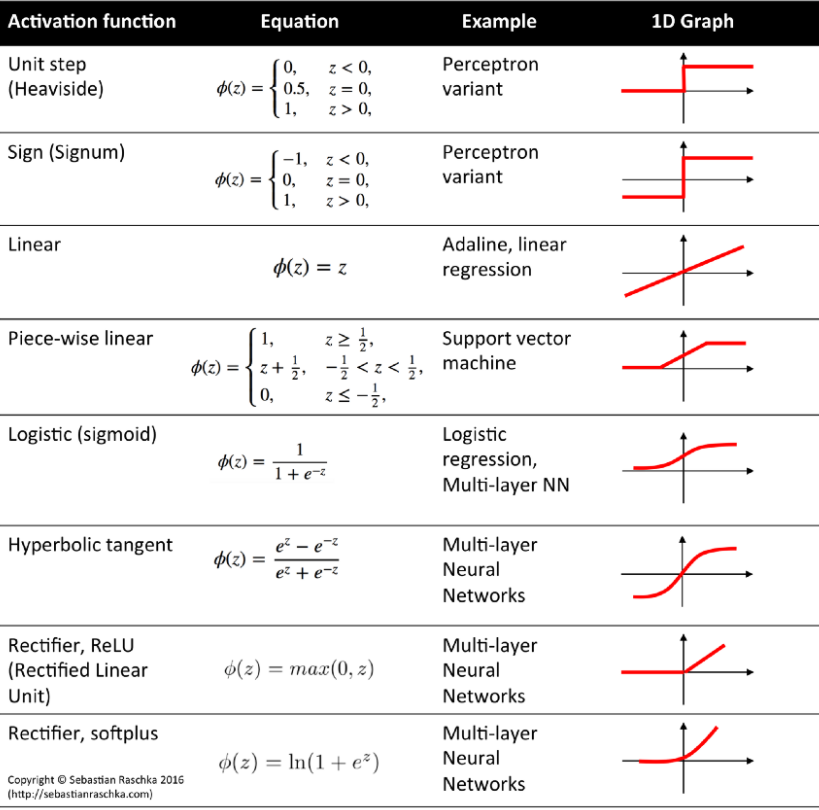

In [15]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=256, verbose=2)

Epoch 1/100
8/8 - 2s - loss: 0.0020
Epoch 2/100
8/8 - 0s - loss: 0.0014
Epoch 3/100
8/8 - 0s - loss: 0.0012
Epoch 4/100
8/8 - 0s - loss: 9.8943e-04
Epoch 5/100
8/8 - 0s - loss: 8.0777e-04
Epoch 6/100
8/8 - 0s - loss: 6.3449e-04
Epoch 7/100
8/8 - 0s - loss: 4.9373e-04
Epoch 8/100
8/8 - 0s - loss: 3.7309e-04
Epoch 9/100
8/8 - 0s - loss: 2.7288e-04
Epoch 10/100
8/8 - 0s - loss: 2.0393e-04
Epoch 11/100
8/8 - 0s - loss: 1.5268e-04
Epoch 12/100
8/8 - 0s - loss: 1.2027e-04
Epoch 13/100
8/8 - 0s - loss: 1.0132e-04
Epoch 14/100
8/8 - 0s - loss: 9.2119e-05
Epoch 15/100
8/8 - 0s - loss: 8.8240e-05
Epoch 16/100
8/8 - 0s - loss: 8.6342e-05
Epoch 17/100
8/8 - 0s - loss: 8.5759e-05
Epoch 18/100
8/8 - 0s - loss: 8.5392e-05
Epoch 19/100
8/8 - 0s - loss: 8.5077e-05
Epoch 20/100
8/8 - 0s - loss: 8.4775e-05
Epoch 21/100
8/8 - 0s - loss: 8.4413e-05
Epoch 22/100
8/8 - 0s - loss: 8.4268e-05
Epoch 23/100
8/8 - 0s - loss: 8.3674e-05
Epoch 24/100
8/8 - 0s - loss: 8.3395e-05
Epoch 25/100
8/8 - 0s - loss: 8.3086e

### Predictions
Grace à model.predict() nous pouvons utiliser notre training set pour voir le résultat de l'entrainement du modèle.
Ici nous testons avec le training pour vérifier s'il retombe sur les bonnes données avec lesquelles il s'est entrainé, et nous lui donnons aussi de nouvelles données pour avoir une prédiction.


In [16]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

![image.png](attachment:image.png)

Nous devons inverser les predictions avant de calculer l'erreur pour que les unités correspondent avec notre dataset original.

In [17]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

### Scores
Nous calculons ici les scores pour apprécier la performance du modèle en training versus en Test


In [18]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 439.44 RMSE
Test Score: 2905.15 RMSE


### Plotting
Ici nous préparons le plot et l'affichage de la prédiction finale. Les arrays ne sont pas de même tailles on doit donc les arranger afin de pouvoir  les afficher simultanément. Pour cela on rajoute des nan pour que les arrays soit de même tailles et donc de pouvoir les plots. On utilise xticks pour choisir le nombre de valeur à afficher car sinon nous en aurions beaucoup trop et les valeurs en abscisse (Date) seraient illisibles.


In [19]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
 

In [20]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict
 


# Graphiques de nos resultats

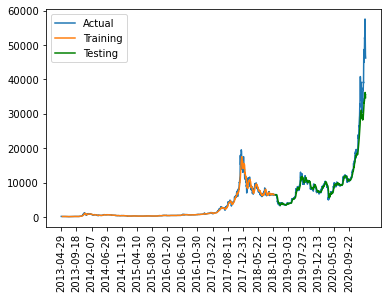

In [21]:
plt.plot(final_data['Date'],final_data["Cours_Bitcoin"], label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=final_data.index).close, label='Training')
plt.plot(final_data['Date'],pd.DataFrame(testPredictPlot, columns=["close"]), 'g',label='Testing')
plt.legend(loc='best')
plt.xticks(np.linspace(0,2846,20,endpoint=False,dtype=int),rotation =90)
plt.show()

# Zoom sur nos prédictions (X/Y Test)

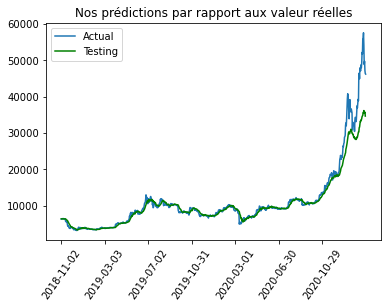

In [22]:
plt.plot(final_data['Date'][2013:],final_data["Cours_Bitcoin"][2013:], label='Actual')
plt.plot(final_data['Date'][2013:],pd.DataFrame(testPredictPlot[2013:], columns=["close"]), 'g',label='Testing')
plt.title("Nos prédictions par rapport aux valeur réelles")
#lt.xticks(np.arange(0,849,int(849/5)),rotation =55)
plt.xticks(np.linspace(0,849,7,endpoint=False,dtype=int),rotation =55)
plt.legend(loc='best')
plt.show()